In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

2023-10-18 12:25:36.290945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-18 12:25:36.291014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-18 12:25:36.291020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Check the math

In [2]:
M = 128
size = 10000

a = randn(M)
c = randn()*M

norm = np.linalg.norm(a)
u = a/norm

gamma = -(1 - (c/norm)**2)
Sigma = np.eye(M) + gamma*np.outer(u,u)

x = np.random.multivariate_normal(
    np.zeros(M), Sigma, size=size
)

f = (x @ a)**2
expval = np.mean(f)

expval, c**2

(7848.200152843943, 7872.349087214072)

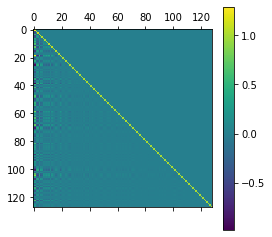

In [3]:
matshow(cholesky(Sigma)); colorbar();

Now using Cholesky downdate

In [4]:
from tensorflow_probability.substrates.jax.math import cholesky_update as jax_cholesky_update

nugget = M*jnp.finfo(float).eps
I = jnp.diag(jnp.repeat(1. + nugget, M))
L = jax_cholesky_update(I, u, gamma) # O(M²)

x = L @ randn(M, size)
x = x.T

f = (x @ a)**2
expval = np.mean(f)

expval, c**2

(DeviceArray(7857.7500503, dtype=float64), 7872.349087214072)

## Check if sampled DGFs actually have the prescribed flow

REGULARIZING FOR TOTAL GLOTTAL FLOW

We regularize for DGF samples to have approximately the same glottal flow as our exact reference model, the exact RBF.
The effect of this is that GF samples tend to be either negative or positive and not both at both short and long lengthscales (extremer values or $r$).

---
Bottom line:

$|a|^2 \rightarrow 0$ when $r \rightarrow r_{min}$, because the basis functions become more wiggly.
And $|a|^2$ is the expected flow squared without regularization for total glottal flow.
And we *know* that the flow is typically nonzero even with short lengthscales $\ell = rT$.
So we regularize "against" this phenomenon using $c^2$ to impose an expected nonzero glottal flow even with very wiggly DGF.
And we can simply *set* $c \propto (OQ*T)^2$ to fix the scale of the DGF and use $\sigma$ (amplitude scale of the DGF) and the coefficients of the filter impulse response $h(t)$ to patch things up.
So our regularization really kicks in when $r < r_{typical} \sim 1/\pi$ and this is precisely what we want.

**Surprise!** It also works the other way.
$|a|^2 \rightarrow 0$ when $r \rightarrow r_{max}$, because the integral constraint becomes very strong and the basis functions are "quelched".
And in this case too the regularizer comes to save the day but not fixing the GF sign (because at this large scale (value of $r$) the GF is always completely + or -) BUT by rescaling the amplitudes back into O(1) domain.
Which is what we want.

We can find $c$ analytically by demanding that $c = |a|(r=1/\pi)$ for the exact RBF kernel such that no regularization occurs at that point.
This yields $c = 0.0969358 (OQ*T)^2$ as our reference value.
See expected-glottal-flow.nb.
(The OQ factor changes nothing specially since it is equivalent to replacing $T \rightarrow OQ*T$.)

**Nice.** Our analytical value for $c$ has the same $\propto (OQ*T)^2$ dependency as predicted by analytical DGF models (Doval+ (2006) eq. 3, their $I$ is our $c$) and by simple triangular DGF models (private correspondence Alku 2023).

Another approach is to actually turn this into yet another source parameter and set something like $c \sim N(c^*,1)$ where $c^* = 0.0969358 (OQ T)^2$.

---

Other raw observations:

The strength of the regularization is $\gamma = -(1 - (c/|a|)^2))$ and no regularization is done when $\gamma = 0$.
This implies that the expected value of the total glottal flow squared is $|a|^2$, which is confirmed numerically.

The main way to get very strong regularization is to set $c >> T \sigma$ -- then `chol` will pick out basisfunctions with similar polarity, such that the total flow is large.
(Here $\sigma$ is the GP variance sigma.)

Any value of $c$ is accepted because `chol` will rescale the amplitudes as necessary.
I think we can fix $c$ to some nominal value and $\sigma \in [10^{-3},10^2]$ will take care of it.
All source parameters $\theta^S$ influence the value of $a$, in particular $a \propto \sigma^s$.

Regularization mainly kicks in when $r < 1/\pi$, since then the glottal flow loses lengthscale structure and tends to have a flow that is neither fully positive nor fully negative.
This is what we want, because trouble usually happens when $r$ is very small (O(0.01)).
When $r ~ 1/\pi$ and larger, the GF usually stays signed, so perfect.

The distribution of the total glottal flow squared is a rescaled chi-squared distribution with $M$ degrees of freedom. Its mean does correspond to $c$, so our ME trick worked.
Nevertheless, the variance is large, so the constraint is relatively weak in general.

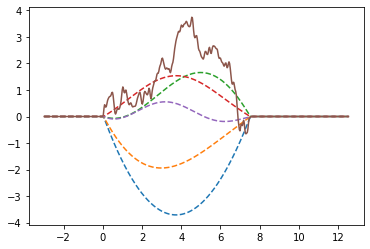

In [5]:
T = 7.545
N = 500
M = 256
bf = 2.
L = T*bf
t, dt = jnp.linspace(-3., T+5, N, retstep=True)

kernel = isokernels.Matern32Kernel
var = 17.5
r = .005
scale = r*T

Ru = core.kernelmatrix_root_gfd(
    kernel, var, scale, t, M, T, bf, integrate=True
)

plot(t, Ru[:,:5], ls="--");
plot(t, Ru @ randn(M));

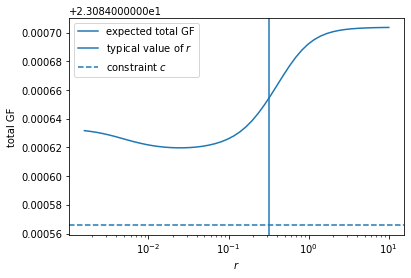

In [6]:
from lib import constants

def expected_glottal_flow(r):
    scale = r*T
    Ru = core.kernelmatrix_root_gfd(
        kernel, var, scale, t, M, T, bf, integrate=True
    )
    a = (np.cumsum(Ru, axis=0)*dt)[-1,:]
    norm = np.linalg.norm(a)
    return norm

c = 0.0969358*sqrt(var)*T**2

rs = np.logspace(log10(constants.MIN_R), log10(constants.MAX_R), 50)
plot(rs, np.vectorize(expected_glottal_flow)(rs), label="expected total GF")
xlabel("$r$")
ylabel("total GF")
xscale('log')
axvline(1/pi, label="typical value of $r$");
axhline(c, ls="--", label="constraint $c$")

legend();

-5.200484633149927e-06

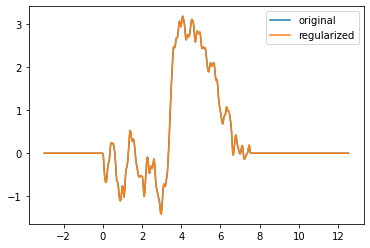

In [32]:
a = np.sum(Ru, axis=0)*dt # This can be done analytically
#c = (1/8)*T**2
c = 0.0969358*sqrt(var)*T**2

norm = np.linalg.norm(a)
u = a/norm

gamma = -(1 - (c/norm)**2)
nugget = M*jnp.finfo(float).eps
I = jnp.diag(jnp.repeat(1. + nugget, M))
chol = jax_cholesky_update(I, u, gamma) # O(M²)

x = randn(M)
y = chol @ x

gfx = Ru @ x
gfy = Ru @ y

plot(t, gfx, label="original")
plot(t, gfy, label="regularized")
legend()

gamma

(DeviceArray(532.35401507, dtype=float64), 532.8971809461833)

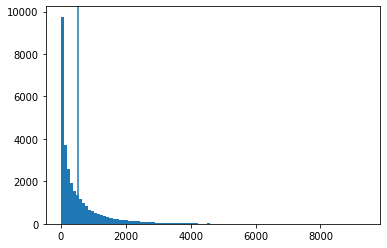

In [8]:
size = 30000

flow = np.sum(Ru @ chol @ randn(M, size), axis=0)*dt
hist(np.array(flow)**2, bins=100)
axvline(c**2)
mean(flow**2), c**2

(DeviceArray(521.22977086, dtype=float64), 532.8999522841963)

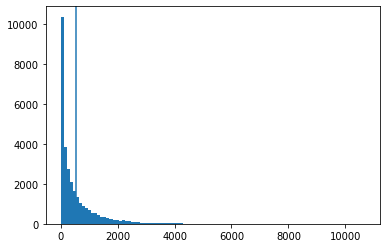

In [9]:
size = 30000

flow = np.sum(Ru @ randn(M, size), axis=0)*dt
hist(np.array(flow)**2, bins=100)
axvline(norm**2)
mean(flow**2), norm**2